In [227]:
import numpy as np
import pandas as pd
import random as random
import matplotlib.pyplot as plt
from datetime import datetime
import wrds
import warnings
from scipy import stats
warnings.simplefilter(action='ignore', category=FutureWarning)

db = wrds.Connection(wrds_username = 'anita97') 

Loading library list...
Done


## a)

In [228]:
#import stocks
'''s = db.raw_sql("select a.permno, a.date, \
                  a.ret, a.shrout, a.prc \
                  from crsp.msf as a \
                  join crsp.msenames as b \
                  on a.permno = b.permno and b.namedt<=a.date \
                  and a.date<=b.nameendt \
                  where b.shrcd between (10) and (11)and \
                  a.date >='2000-01-01' and a.date<='2019-12-31'\
                  and b.exchcd between 1 and 2")'''

's = db.raw_sql("select a.permno, a.date,                   a.ret, a.shrout, a.prc                   from crsp.msf as a                   join crsp.msenames as b                   on a.permno = b.permno and b.namedt<=a.date                   and a.date<=b.nameendt                   where b.shrcd between (10) and (11)and                   a.date >=\'2000-01-01\' and a.date<=\'2019-12-31\'                  and b.exchcd between 1 and 2")'

In [233]:
#s.to_csv('as6.csv')
stocks = pd.read_csv('as6.csv', index_col=0) # read the file

For each value we want one value for each month. Firstly we trasform data column in month-year(format). Then, for each stock we chack that there is only one value for each month:

In [234]:
stocks.date = pd.DatetimeIndex(stocks.date) # data format
stocks.date = stocks.date.dt.to_period('M') # data year-month
stocks.head() # see data format

,permno,date,ret,shrout,prc
0,10001.0,2009-12,0.162621,4361.0,10.3000
1,10001.0,2010-01,-0.018932,4361.0,10.0600
2,10001.0,2010-02,-0.000656,4361.0,10.0084
3,10001.0,2010-03,0.020643,4361.0,10.1700
4,10001.0,2010-04,0.124385,6070.0,11.3900


PERMNO is a unique stock level identifier. While most of the companies have one class shares, some companies have more than one class shares traded at different prices, and this is the reason why a company can have more than one PERMNOs.

We utilize permno as index:

In [235]:
stocks.sort_values(by='permno')
stocks = stocks.drop_duplicates(['permno','date']) # delete duplicates
stocks = stocks.set_index('permno') # set permno as index
stocks.head()

,date,ret,shrout,prc
permno,,,,
10001.0,2009-12,0.162621,4361.0,10.3000
10001.0,2010-01,-0.018932,4361.0,10.0600
10001.0,2010-02,-0.000656,4361.0,10.0084
10001.0,2010-03,0.020643,4361.0,10.1700
10001.0,2010-04,0.124385,6070.0,11.3900


We have to delete all the stocks which have less than 240 observations. In order to do that, we can group all the stocks on permno (which identify one stock) and then count how many observations we have for each stock:

In [236]:
count = []
count = stocks.groupby('permno').count()
# now in each column we have the number of observations. We can rename one of them
count = count.rename(columns={"date":"number of observations"})
count = count[['number of observations']]
print(f"We have {count.shape[0]} different stocks. Each has a certain number of observations:")
count.head()


We have 4118 different stocks. Each has a certain number of observations:


,number of observations
permno,
10001.0,92
10028.0,140
10042.0,98
10051.0,233
10066.0,28


Now we delete  stocks with less than 240 observations:

Note: This is equal to have only stocks with preciselt 240 observations. Because we want that they are traded EVERY mounth for 20 years: 

20 years*12 mounths = 240 observation. 

In [237]:
decision = count[['number of observations']]!=240 # delete if true
decision = decision.dropna() # drop NaN
decision.head()

,number of observations
permno,
10001.0,True
10028.0,True
10042.0,True
10051.0,True
10066.0,True


In [238]:
decision_true = decision[decision['number of observations']] # keep only true
print(f"We delete {decision_true.shape[0]} stocks.")
stocks_del = stocks.drop(index=decision_true.index) # drop
stocks_del.head()

We delete 3479 stocks.


,date,ret,shrout,prc
permno,,,,
10145.0,2000-01,-0.167931,789233.0,48.0000
10145.0,2000-02,0.006510,795134.0,48.1250
10145.0,2000-03,0.094805,796591.0,52.6875
10145.0,2000-04,0.062871,796591.0,56.0000
10145.0,2000-05,-0.020089,798161.0,54.6875


We should have 639 stocks:

In [239]:
# we have deleted decision_true
# we are left with the rest of decision
num_deleted = int(decision_true.count())
num_left = int(decision.count()-decision_true.count())
print(f"We have deleted {num_deleted} and we are left with {num_left} stocks")

We have deleted 3479 and we are left with 639 stocks


In [240]:
# import risk free rate
risk_free = db.raw_sql("select mcaldt as date, tmytm as rf from crsp.tfz_mth_rf where kytreasnox = 2000001 and mcaldt>='2000-01-01' and mcaldt<='2019-12-31'")
risk_free_m = np.exp(np.divide(risk_free.rf, 1200)) -1
rf = pd.DataFrame([risk_free.date, risk_free_m], index=['date', 'rf']).T

# import market
market = db.raw_sql("select date, vwretd from crsp.msi where date>='2000-01-01' and date<='2019-12-31'")
market_m = pd.DataFrame([market.date, market.vwretd.values], index=['date', 'mkt_ret']).T
rm = market_m.set_index('date')

In [241]:
rf.date = pd.DatetimeIndex(rf.date) # data format
rf.date = rf.date.dt.to_period('M') # data year-month
#rf = rf.drop('index')
rf = rf.set_index('date')
rf.head()

,rf
date,
2000-01,0.00449835
2000-02,0.00443834
2000-03,0.00489188
2000-04,0.00440126
2000-05,0.00390314


In [242]:
rm.index = pd.DatetimeIndex(rm.index) # data format
rm.index = rm.index.to_period('M') # data year-month
rm.head()

,mkt_ret
date,
2000-01,-0.0396243
2000-02,0.0317784
2000-03,0.0535007
2000-04,-0.059527
2000-05,-0.0388696


We set a multiple index for the stocks:

In [243]:
# change index: first permno then date
ss_permno = stocks_del.reset_index()
ss_permno = ss_permno.set_index(['permno','date']) # multiple index
ss_permno = ss_permno.sort_values(by=['permno','date']) # sort
ss_permno.head()

ret    shrout      prc
permno  date                                
10145.0 2000-01 -0.167931  789233.0  48.0000
        2000-02  0.006510  795134.0  48.1250
        2000-03  0.094805  796591.0  52.6875
        2000-04  0.062871  796591.0  56.0000
        2000-05 -0.020089  798161.0  54.6875

In [244]:
# change index: first date then permno
ss_date = ss_permno.reset_index()
ss_date = ss_date.set_index(['date','permno']) # multiple index
ss_date = ss_date.sort_values(by=['date','permno']) # sort
ss_date.head()

ret    shrout      prc
date    permno                              
2000-01 10145.0 -0.167931  789233.0  48.0000
        10294.0 -0.072816    4786.0  11.9375
        10308.0 -0.038961    7040.0  27.7500
        10516.0 -0.030928  608360.0  11.7500
        10517.0 -0.078767    3830.0 -16.8125

## b)

Using the full sample, estimate the market beta for each stock:

Beta = Cov (R,Rm) / var(Rm)

In [245]:
# list of right permnos (no duplicates):
list_permno = list(stocks_del.loc[~stocks_del.index.duplicated(keep='first')].index)

In [246]:
market_beta = []

#cycle for each stock (639 elemts)
for i in list_permno: # (list_permno): 
        current_stock = stocks_del.loc[i] # long 240 because we have 240 observations for each stock
        ret_cur_stock = current_stock.ret.values.astype(float) # 240 returns for each stock
        rm_cur_stock = rm.loc[current_stock.date].mkt_ret.astype(float)
        covariance = np.cov(ret_cur_stock, rm_cur_stock) # Cov(R,Rm)
        var_market = covariance[1,1]
        market_beta.append(covariance[0,1]/var_market)

#market_beta

Create a DataFrame where for each stock we have its beta

In [247]:
data = pd.DataFrame(market_beta, columns={'beta'}, index=list_permno) # for each stock we have its beta
#data = data.mul(240) # multiplicate di merge the dataset
data = data.sort_index()
data.head()

,beta
10145.0,1.200190
10294.0,0.758752
10308.0,0.443625
10516.0,0.497710
10517.0,0.642811


We add to the stocks dataframe our beta, creating a new column:

In [248]:
stocks_del = stocks_del.merge(data, left_index=True, right_index=True)
stocks_del['permno'] = stocks_del.index
stocks_with_beta = stocks_del.set_index(['permno','date']) # re-index
stocks_with_beta.head()

ret    shrout      prc     beta
permno  date                                         
10145.0 2000-01 -0.167931  789233.0  48.0000  1.20019
        2000-02  0.006510  795134.0  48.1250  1.20019
        2000-03  0.094805  796591.0  52.6875  1.20019
        2000-04  0.062871  796591.0  56.0000  1.20019
        2000-05 -0.020089  798161.0  54.6875  1.20019

Sort stocks by beta into 10 decile portfolios

In [249]:
decile = pd.DataFrame(pd.qcut(data.beta,10),index=list_permno, columns=["beta"])
decile = decile.rename(columns={'beta':'decile'})
decile.head()

,decile
10145.0,"(1.151, 1.296]"
10294.0,"(0.744, 0.882]"
10308.0,"(0.425, 0.607]"
10516.0,"(0.425, 0.607]"
10517.0,"(0.607, 0.744]"


At this point we should have 10 porfolios:

In [250]:
inters = pd.qcut(data.beta,10).values
inters = list(dict.fromkeys(inters))
#inters.sort()
inters = [x for x in inters if str(x) != 'nan'] # drop NoN. We always put a control just to be sure
print(f"We have {len(inters)} portfolios")

We have 10 portfolios


In [251]:
group_decile = decile.sort_values(by="decile") # sort for decile
group_decile.reset_index(inplace=True)
group_decile = group_decile.dropna() # drop NaN
group_decile = group_decile.groupby("decile")

Equal weighted average return for each portfolio:

In [252]:
ew_ret = [] 
avg_beta = []
for i in inters:
    stock_interval = group_decile.get_group(i)["index"]
    temp = stocks_del.loc[stock_interval] 
    group_date = temp.groupby('date').mean()
    ew_ret.append(group_date.ret.mean()) # equal weighted => mean
    avg_beta.append(data.loc[stock_interval].mean()[0])

We create a dataframe to show the relation between beta and returns of our 10 portfolios

In [263]:
ret = pd.DataFrame([ew_ret,avg_beta]).transpose() 
ret = ret.rename(columns={0:'ew_ret',1:'avg_beta'})
ret = ret.sort_values(by='avg_beta')
ret = ret.set_index('avg_beta')
ret.head(10)

,ew_ret
avg_beta,
0.285315,0.010578
0.515390,0.011674
0.685130,0.011796
0.818324,0.012387
0.944647,0.012547
1.072443,0.011389
1.221790,0.011606
1.361476,0.013521
1.539029,0.012934


In [264]:
rm_mean = rm.mkt_ret.mean() 
rf_mean = rf.rf.mean()
excess_rm_rf = rm_mean-rf_mean
print(f"The market has a mean return of {rm_mean} and \nthe risk-free portfolio of {rf_mean}.")

The market has a mean return of 0.005825365536250002 and 
the risk-free portfolio of 0.0013152996576685284.


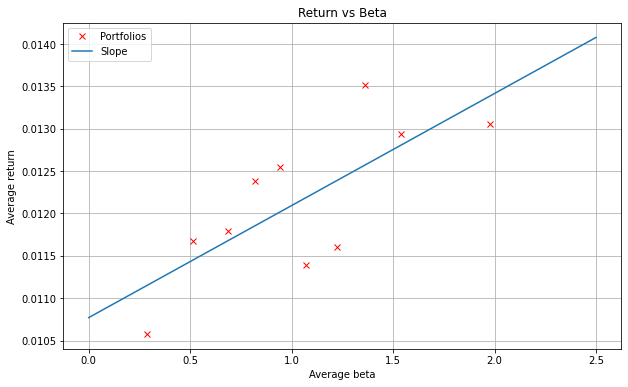

In [267]:
slope, intercept, r_value, p_value, std_err =  stats.linregress([avg_beta[i] for i in range(len(avg_beta))],ew_ret)
plt.figure(figsize=(10,6))
plt.plot(avg_beta, ew_ret, 'rx', label='Portfolios')
#plt.plot(np.linspace(0,2.5,100), rf_mean + np.linspace(0,2.5,100)*excess_rm_rf, label='CAPM')
plt.plot(np.linspace(0,2.5,100),np.linspace(0,2.5,100)*slope+intercept,label = 'Slope')
plt.title('Return vs Beta')
plt.xlabel('Average beta')
plt.ylabel('Average return')
plt.grid()
plt.legend(loc='best')
plt.show()

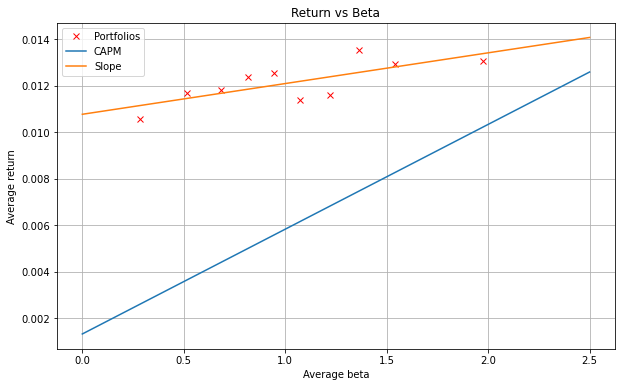

In [268]:
slope, intercept, r_value, p_value, std_err =  stats.linregress([avg_beta[i] for i in range(len(avg_beta))],ew_ret)
plt.figure(figsize=(10,6))
plt.plot(avg_beta, ew_ret, 'rx', label='Portfolios')
plt.plot(np.linspace(0,2.5,100), rf_mean + np.linspace(0,2.5,100)*excess_rm_rf, label='CAPM')
plt.plot(np.linspace(0,2.5,100),np.linspace(0,2.5,100)*slope+intercept,label = 'Slope')
plt.title('Return vs Beta')
plt.xlabel('Average beta')
plt.ylabel('Average return')
plt.grid()
plt.legend(loc='best')
plt.show()